# 3D Volume Visualization for BlastoSpim Data

This notebook provides comprehensive tools for visualizing raw 3D volumes from BlastoSpim microscopy data.

## Overview
- **Dataset**: BlastoSpim 3D microscopy NPZ files
- **Voxel Spacing**: Z=2.0µm, Y/X=0.208µm (anisotropic)
- **Visualization Types**: Multi-slice views, 3D rendering, interactive exploration
- **Analysis**: Volume statistics, intensity distribution, spatial analysis

## Features
- ✅ Interactive 3D volume rendering with Plotly
- ✅ Multi-slice visualization across all axes
- ✅ Intensity analysis and histogram plots
- ✅ Volume statistics and metadata display
- ✅ Configurable visualization parameters
- ✅ Export capabilities for figures
- ✅ Proper anisotropic voxel spacing handling

## 1. Import Required Libraries

Import all necessary libraries for 3D visualization, data analysis, and interactive plotting.

In [2]:
# Standard library imports
import sys
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Scientific computing and data analysis
import numpy as np
import pandas as pd
from scipy import ndimage
from skimage import measure, filters, segmentation

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import seaborn as sns

# Interactive 3D visualization
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.offline as pyo

# Set up project paths
project_root = '/mnt/home/dchhantyal/centroid_model_blastospim'
if project_root not in sys.path:
    sys.path.append(project_root)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

print("✅ All libraries imported successfully!")
print(f"✅ Project root: {project_root}")
print(f"✅ Key libraries:")
print(f"   - NumPy: {np.__version__}")
print(f"   - Matplotlib: {plt.matplotlib.__version__}")
print(f"   - Scikit-image available for analysis")
print(f"   - SciPy available for filtering")

✅ All libraries imported successfully!
✅ Project root: /mnt/home/dchhantyal/centroid_model_blastospim
✅ Key libraries:
   - NumPy: 2.1.3
   - Matplotlib: 3.10.3
   - Scikit-image available for analysis
   - SciPy available for filtering


## 2. Configuration and Parameters

Set up visualization parameters and BlastoSpim-specific voxel spacing configuration.

In [3]:
# BlastoSpim voxel spacing (from research paper)
VOXEL_SPACING = {
    'z': 2.0,    # µm - axial resolution
    'y': 0.208,  # µm - lateral resolution 
    'x': 0.208   # µm - lateral resolution
}

# Convert to tuple for calculations
voxel_spacing = (VOXEL_SPACING['z'], VOXEL_SPACING['y'], VOXEL_SPACING['x'])

# Visualization parameters
VIZ_CONFIG = {
    # Figure settings
    'figsize': (15, 10),
    'dpi': 100,
    'cmap_volume': 'viridis',
    'cmap_labels': 'tab20',
    
    # 3D rendering settings
    'opacity': 0.3,
    'surface_count': 5,
    'colorscale': 'Viridis',
    
    # Slice visualization
    'slice_step': 5,  # Show every Nth slice
    'max_slices_display': 6,  # Maximum slices to show in grid
    
    # Interactive settings
    'plotly_height': 600,
    'plotly_width': 800,
    
    # Analysis settings
    'histogram_bins': 50,
    'percentile_range': (1, 99),  # For intensity normalization
}

# Data directories
RAW_DATA_DIR = Path(project_root) / "data" / "raw" / "Blast"
OUTPUT_DIR = Path(project_root) / "visualizations" / "3d_volumes"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"✅ Configuration loaded successfully")
print(f"📐 Voxel spacing: Z={VOXEL_SPACING['z']}µm, Y={VOXEL_SPACING['y']}µm, X={VOXEL_SPACING['x']}µm")
print(f"📊 Anisotropy ratio: {VOXEL_SPACING['z']/VOXEL_SPACING['x']:.1f}:1 (Z:X)")
print(f"📂 Raw data directory: {RAW_DATA_DIR}")
print(f"💾 Output directory: {OUTPUT_DIR}")
print(f"🎨 Default colormap: {VIZ_CONFIG['cmap_volume']}")
print(f"📱 Interactive plots: Plotly {VIZ_CONFIG['plotly_width']}x{VIZ_CONFIG['plotly_height']}")

✅ Configuration loaded successfully
📐 Voxel spacing: Z=2.0µm, Y=0.208µm, X=0.208µm
📊 Anisotropy ratio: 9.6:1 (Z:X)
📂 Raw data directory: /mnt/home/dchhantyal/centroid_model_blastospim/data/raw/Blast
💾 Output directory: /mnt/home/dchhantyal/centroid_model_blastospim/visualizations/3d_volumes
🎨 Default colormap: viridis
📱 Interactive plots: Plotly 800x600


## 3. Data Loading and Selection

Load and inspect available NPZ files, then select a file for visualization.

In [5]:
# Search for available NPZ files
npz_files = list(RAW_DATA_DIR.glob("*.npz"))
npz_files.sort()
FILE_NAME = "Blast_009.npz"  # Example file name for reference

print(f"🔍 Found {len(npz_files)} NPZ files in {RAW_DATA_DIR}")

if len(npz_files) == 0:
    print("❌ No NPZ files found!")
    print(f"💡 Please ensure NPZ files are present in: {RAW_DATA_DIR}")
    print("💡 Or modify RAW_DATA_DIR to point to your data")
else:
    print(f"\n📁 Available files (showing first 10):")
    for i, file_path in enumerate(npz_files[:10], 1):
        file_size = file_path.stat().st_size / (1024**2)  # Size in MB
        print(f"   {i:2d}. {file_path.name:<20} ({file_size:.1f} MB)")
    
    if len(npz_files) > 10:
        print(f"   ... and {len(npz_files) - 10} more files")

# Select a file for visualization (you can change this index)
FILE_INDEX = npz_files.index(Path(RAW_DATA_DIR) / FILE_NAME) if FILE_NAME in [f.name for f in npz_files] else 0

if len(npz_files) > 0:
    selected_file = npz_files[FILE_INDEX] if FILE_INDEX < len(npz_files) else npz_files[0]
    print(f"\n🎯 Selected file for visualization:")
    print(f"   📄 File: {selected_file.name}")
    print(f"   📁 Path: {selected_file}")
    print(f"   💾 Size: {selected_file.stat().st_size / (1024**2):.1f} MB")
    
    # Quick inspection of the file contents
    with np.load(selected_file) as data:
        available_keys = list(data.keys())
        print(f"   🔑 Available keys: {available_keys}")
        
        # Try to get volume shape information
        for key in ['volume', 'data', 'image', 'raw']:
            if key in available_keys:
                volume_shape = data[key].shape
                volume_dtype = data[key].dtype
                print(f"   📐 Volume shape ({key}): {volume_shape}")
                print(f"   🔢 Data type: {volume_dtype}")
                break
    
    print(f"\n💡 To visualize a different file, change FILE_INDEX (0-{len(npz_files)-1}) and re-run this cell")
else:
    selected_file = None

🔍 Found 80 NPZ files in /mnt/home/dchhantyal/centroid_model_blastospim/data/raw/Blast

📁 Available files (showing first 10):
    1. Blast_001.npz        (1092.0 MB)
    2. Blast_002.npz        (1152.0 MB)
    3. Blast_003.npz        (1152.0 MB)
    4. Blast_004.npz        (1212.0 MB)
    5. Blast_005.npz        (1212.0 MB)
    6. Blast_006.npz        (1212.0 MB)
    7. Blast_007.npz        (1212.0 MB)
    8. Blast_008.npz        (1212.0 MB)
    9. Blast_009.npz        (1212.0 MB)
   10. Blast_010.npz        (1212.0 MB)
   ... and 70 more files

🎯 Selected file for visualization:
   📄 File: Blast_009.npz
   📁 Path: /mnt/home/dchhantyal/centroid_model_blastospim/data/raw/Blast/Blast_009.npz
   💾 Size: 1212.0 MB
   🔑 Available keys: ['img', 'labels']

💡 To visualize a different file, change FILE_INDEX (0-79) and re-run this cell


## 4. Load and Inspect 3D Volume

Load the selected volume and perform initial analysis including shape, data type, and intensity statistics.

In [6]:
if selected_file is not None:
    # Load the volume data
    with np.load(selected_file) as data:
        # Try different common key names for volume data
        volume_keys = ['volume', 'data', 'image', 'raw', 'stack']
        volume = None
        volume_key = None
        
        for key in volume_keys:
            if key in data.keys():
                volume = data[key].copy()
                volume_key = key
                break
        
        # If none of the standard keys found, use the first available key
        if volume is None and len(data.keys()) > 0:
            volume_key = list(data.keys())[0]
            volume = data[volume_key].copy()
            print(f"⚠️  Using key '{volume_key}' as no standard volume key found")
    
    if volume is not None:
        print(f"✅ Volume loaded successfully from key: '{volume_key}'")
        
        # Basic volume information
        print(f"\n📊 VOLUME INFORMATION")
        print(f"   📐 Shape (Z,Y,X): {volume.shape}")
        print(f"   🔢 Data type: {volume.dtype}")
        print(f"   💾 Memory usage: {volume.nbytes / (1024**2):.1f} MB")
        
        # Physical dimensions
        z_size, y_size, x_size = volume.shape
        physical_size = (
            z_size * voxel_spacing[0],
            y_size * voxel_spacing[1], 
            x_size * voxel_spacing[2]
        )
        
        print(f"\n📏 PHYSICAL DIMENSIONS")
        print(f"   Z-axis: {z_size} voxels × {voxel_spacing[0]} µm = {physical_size[0]:.1f} µm")
        print(f"   Y-axis: {y_size} voxels × {voxel_spacing[1]} µm = {physical_size[1]:.1f} µm")
        print(f"   X-axis: {x_size} voxels × {voxel_spacing[2]} µm = {physical_size[2]:.1f} µm")
        print(f"   📦 Total volume: {np.prod(physical_size):.0f} µm³")
        
        # Intensity statistics
        print(f"\n📈 INTENSITY STATISTICS")
        print(f"   🔢 Min value: {np.min(volume)}")
        print(f"   🔢 Max value: {np.max(volume)}")
        print(f"   📊 Mean: {np.mean(volume):.2f}")
        print(f"   📊 Std dev: {np.std(volume):.2f}")
        print(f"   📊 Median: {np.median(volume):.2f}")
        
        # Percentile information for visualization
        p1, p99 = np.percentile(volume, VIZ_CONFIG['percentile_range'])
        print(f"   📊 1st percentile: {p1:.2f}")
        print(f"   📊 99th percentile: {p99:.2f}")
        
        # Check for potential issues
        unique_values = len(np.unique(volume))
        zero_fraction = np.sum(volume == 0) / volume.size
        
        print(f"\n🔍 DATA QUALITY CHECKS")
        print(f"   🎯 Unique values: {unique_values}")
        print(f"   🕳️  Zero fraction: {zero_fraction:.1%}")
        
        if unique_values < 10:
            print(f"   ⚠️  Warning: Very few unique values - might be a label volume")
        if zero_fraction > 0.9:
            print(f"   ⚠️  Warning: >90% zeros - very sparse volume")
        
        print(f"\n✅ Volume analysis complete and ready for visualization!")
        
    else:
        print(f"❌ Could not load volume data from {selected_file}")
        print(f"💡 Available keys were: {list(data.keys())}")
        volume = None
        
else:
    print("❌ No file selected. Please run the previous cell to select a file.")
    volume = None

⚠️  Using key 'img' as no standard volume key found
✅ Volume loaded successfully from key: 'img'

📊 VOLUME INFORMATION
   📐 Shape (Z,Y,X): (101, 2048, 2048)
   🔢 Data type: uint16
   💾 Memory usage: 808.0 MB

📏 PHYSICAL DIMENSIONS
   Z-axis: 101 voxels × 2.0 µm = 202.0 µm
   Y-axis: 2048 voxels × 0.208 µm = 426.0 µm
   X-axis: 2048 voxels × 0.208 µm = 426.0 µm
   📦 Total volume: 36655398 µm³

📈 INTENSITY STATISTICS
   🔢 Min value: 0
   🔢 Max value: 2831
   📊 Mean: 118.83
   📊 Std dev: 9.13
   📊 Median: 118.00
   📊 1st percentile: 109.00
   📊 99th percentile: 132.00

🔍 DATA QUALITY CHECKS
   🎯 Unique values: 2277
   🕳️  Zero fraction: 0.0%

✅ Volume analysis complete and ready for visualization!


## 5. Multi-Slice Visualization

Display multiple slices across different axes to understand the 3D structure.

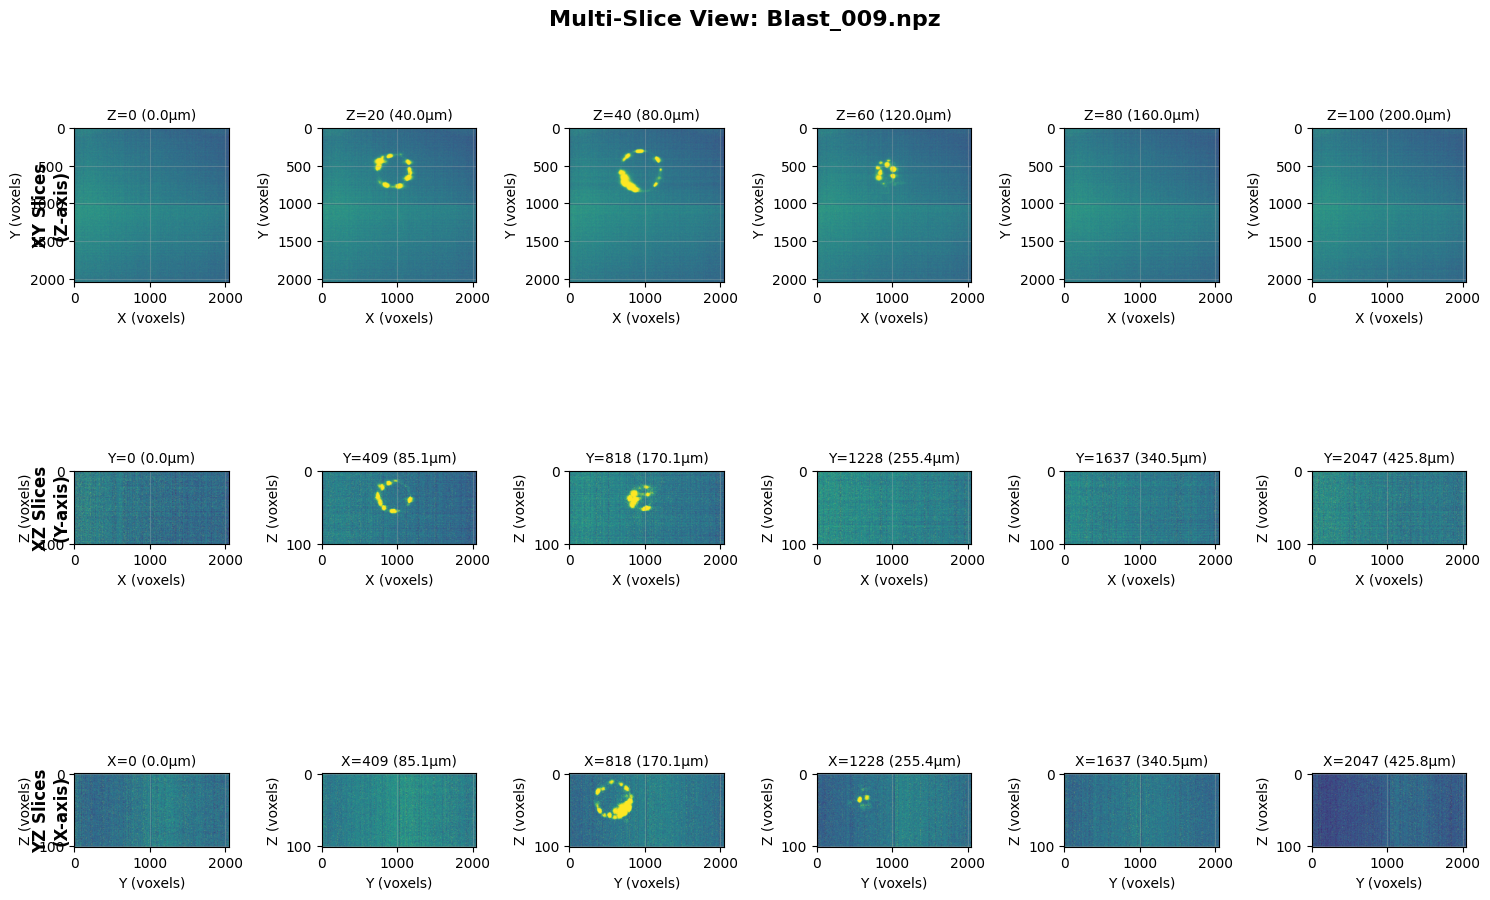


✅ Multi-slice visualization complete!
💾 Saved to: /mnt/home/dchhantyal/centroid_model_blastospim/visualizations/3d_volumes/Blast_009_multi_slice.png
📐 Aspect ratios adjusted for anisotropic voxels
🎨 Intensity normalized to (1, 99) percentile range


In [7]:
if volume is not None:
    # Prepare intensity normalization for better visualization
    p1, p99 = np.percentile(volume, VIZ_CONFIG['percentile_range'])
    volume_norm = np.clip((volume - p1) / (p99 - p1), 0, 1)
    
    # Create multi-slice visualization
    fig, axes = plt.subplots(3, VIZ_CONFIG['max_slices_display'], 
                            figsize=(VIZ_CONFIG['figsize'][0], VIZ_CONFIG['figsize'][1]))
    fig.suptitle(f'Multi-Slice View: {selected_file.name}', fontsize=16, fontweight='bold')
    
    # Z-axis slices (XY planes)
    z_indices = np.linspace(0, volume.shape[0]-1, VIZ_CONFIG['max_slices_display'], dtype=int)
    for i, z_idx in enumerate(z_indices):
        axes[0, i].imshow(volume_norm[z_idx], cmap=VIZ_CONFIG['cmap_volume'], aspect='equal')
        axes[0, i].set_title(f'Z={z_idx} ({z_idx*voxel_spacing[0]:.1f}µm)', fontsize=10)
        axes[0, i].set_xlabel('X (voxels)')
        axes[0, i].set_ylabel('Y (voxels)')
        axes[0, i].grid(True, alpha=0.3)
    
    # Y-axis slices (XZ planes)
    y_indices = np.linspace(0, volume.shape[1]-1, VIZ_CONFIG['max_slices_display'], dtype=int)
    for i, y_idx in enumerate(y_indices):
        axes[1, i].imshow(volume_norm[:, y_idx], cmap=VIZ_CONFIG['cmap_volume'], 
                         aspect=voxel_spacing[0]/voxel_spacing[2])  # Adjust for anisotropic voxels
        axes[1, i].set_title(f'Y={y_idx} ({y_idx*voxel_spacing[1]:.1f}µm)', fontsize=10)
        axes[1, i].set_xlabel('X (voxels)')
        axes[1, i].set_ylabel('Z (voxels)')
        axes[1, i].grid(True, alpha=0.3)
    
    # X-axis slices (YZ planes)
    x_indices = np.linspace(0, volume.shape[2]-1, VIZ_CONFIG['max_slices_display'], dtype=int)
    for i, x_idx in enumerate(x_indices):
        axes[2, i].imshow(volume_norm[:, :, x_idx], cmap=VIZ_CONFIG['cmap_volume'],
                         aspect=voxel_spacing[0]/voxel_spacing[1])  # Adjust for anisotropic voxels
        axes[2, i].set_title(f'X={x_idx} ({x_idx*voxel_spacing[2]:.1f}µm)', fontsize=10)
        axes[2, i].set_xlabel('Y (voxels)')
        axes[2, i].set_ylabel('Z (voxels)')
        axes[2, i].grid(True, alpha=0.3)
    
    # Add row labels
    axes[0, 0].text(-0.15, 0.5, 'XY Slices\n(Z-axis)', transform=axes[0, 0].transAxes, 
                   rotation=90, va='center', ha='center', fontsize=12, fontweight='bold')
    axes[1, 0].text(-0.15, 0.5, 'XZ Slices\n(Y-axis)', transform=axes[1, 0].transAxes, 
                   rotation=90, va='center', ha='center', fontsize=12, fontweight='bold')
    axes[2, 0].text(-0.15, 0.5, 'YZ Slices\n(X-axis)', transform=axes[2, 0].transAxes, 
                   rotation=90, va='center', ha='center', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    
    # Save the figure
    output_filename = OUTPUT_DIR / f"{selected_file.stem}_multi_slice.png"
    plt.savefig(output_filename, dpi=VIZ_CONFIG['dpi'], bbox_inches='tight')
    
    plt.show()
    
    print(f"\n✅ Multi-slice visualization complete!")
    print(f"💾 Saved to: {output_filename}")
    print(f"📐 Aspect ratios adjusted for anisotropic voxels")
    print(f"🎨 Intensity normalized to {VIZ_CONFIG['percentile_range']} percentile range")
    
else:
    print("❌ No volume data available. Please load a volume first.")

## 6. Intensity Analysis and Histograms

Analyze the intensity distribution and create comprehensive statistical plots.

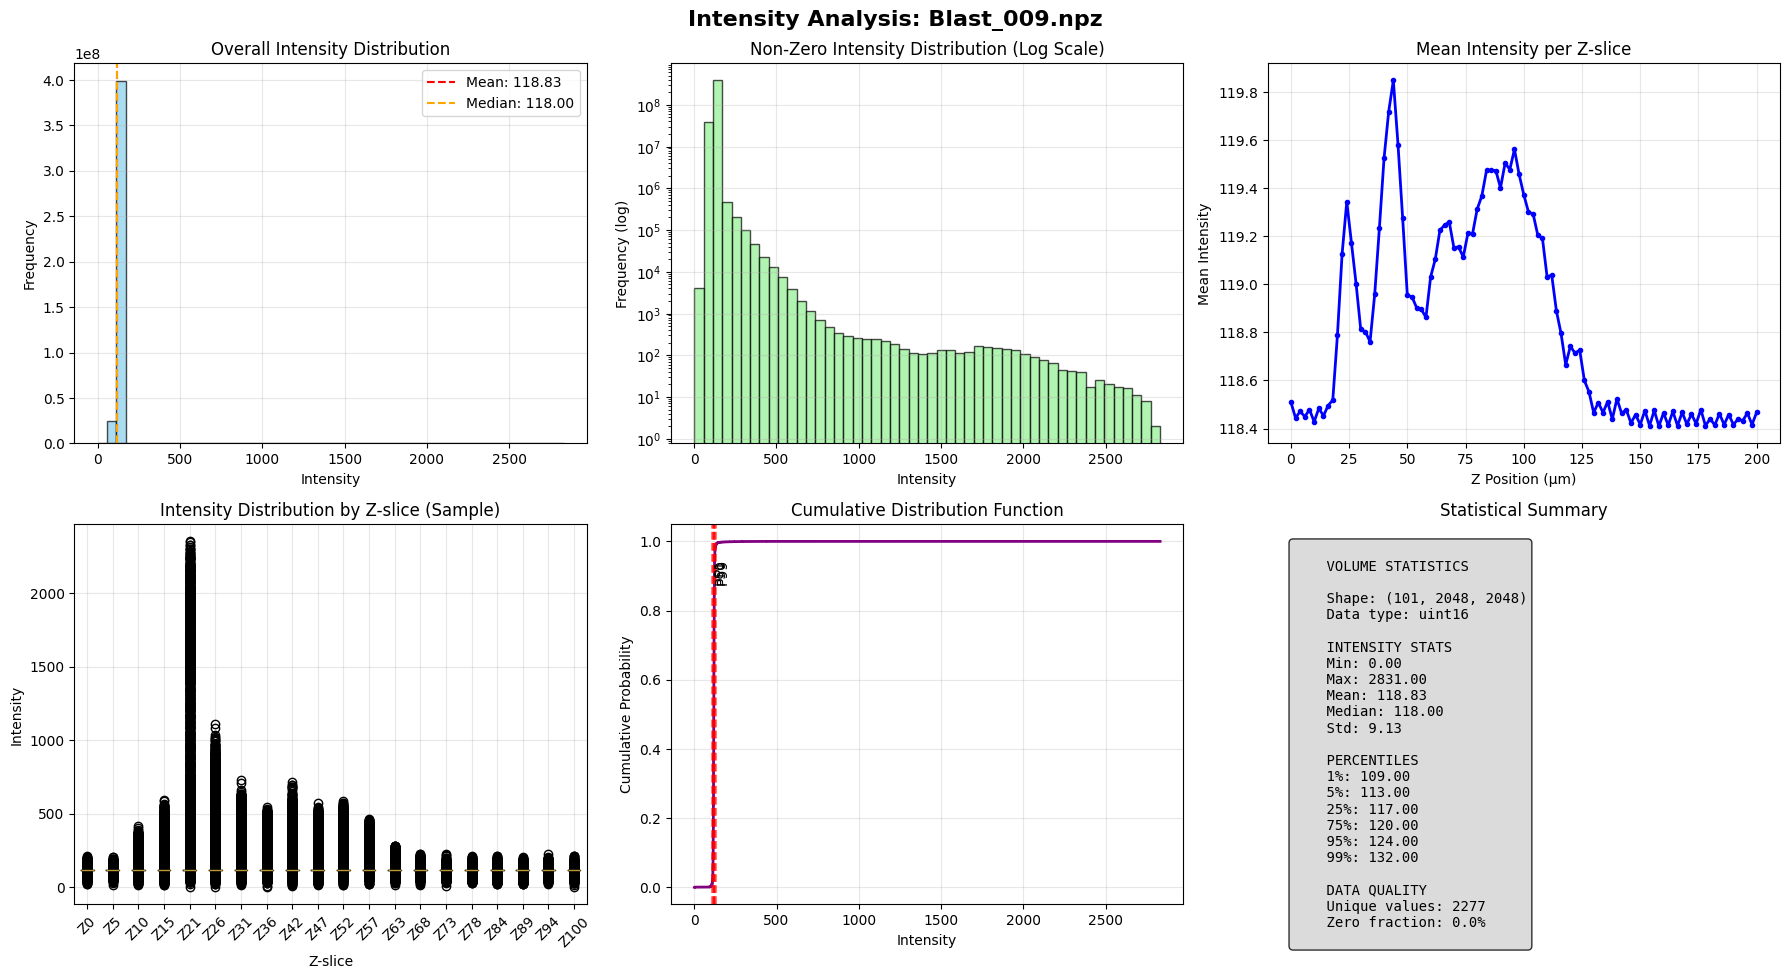


✅ Intensity analysis complete!
💾 Saved to: /mnt/home/dchhantyal/centroid_model_blastospim/visualizations/3d_volumes/Blast_009_intensity_analysis.png
📊 Comprehensive statistics and distributions displayed


In [8]:
if volume is not None:
    # Create intensity analysis figure
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'Intensity Analysis: {selected_file.name}', fontsize=16, fontweight='bold')
    
    # 1. Overall histogram
    axes[0, 0].hist(volume.flatten(), bins=VIZ_CONFIG['histogram_bins'], 
                   alpha=0.7, color='skyblue', edgecolor='black')
    axes[0, 0].set_title('Overall Intensity Distribution')
    axes[0, 0].set_xlabel('Intensity')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].axvline(np.mean(volume), color='red', linestyle='--', label=f'Mean: {np.mean(volume):.2f}')
    axes[0, 0].axvline(np.median(volume), color='orange', linestyle='--', label=f'Median: {np.median(volume):.2f}')
    axes[0, 0].legend()
    
    # 2. Log-scale histogram (if needed)
    non_zero_values = volume[volume > 0]
    if len(non_zero_values) > 0:
        axes[0, 1].hist(non_zero_values, bins=VIZ_CONFIG['histogram_bins'], 
                       alpha=0.7, color='lightgreen', edgecolor='black')
        axes[0, 1].set_yscale('log')
        axes[0, 1].set_title('Non-Zero Intensity Distribution (Log Scale)')
        axes[0, 1].set_xlabel('Intensity')
        axes[0, 1].set_ylabel('Frequency (log)')
        axes[0, 1].grid(True, alpha=0.3)
    else:
        axes[0, 1].text(0.5, 0.5, 'No non-zero values', transform=axes[0, 1].transAxes, 
                       ha='center', va='center')
        axes[0, 1].set_title('Non-Zero Intensity Distribution')
    
    # 3. Slice-wise mean intensity
    z_means = [np.mean(volume[z]) for z in range(volume.shape[0])]
    z_positions = np.arange(volume.shape[0]) * voxel_spacing[0]
    axes[0, 2].plot(z_positions, z_means, 'b-', linewidth=2, marker='o', markersize=3)
    axes[0, 2].set_title('Mean Intensity per Z-slice')
    axes[0, 2].set_xlabel('Z Position (µm)')
    axes[0, 2].set_ylabel('Mean Intensity')
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Box plot of intensity distribution
    # Sample slices for box plot to avoid memory issues
    sample_slices = np.linspace(0, volume.shape[0]-1, min(20, volume.shape[0]), dtype=int)
    slice_data = [volume[z].flatten() for z in sample_slices]
    slice_labels = [f'Z{z}' for z in sample_slices]
    
    axes[1, 0].boxplot(slice_data, labels=slice_labels)
    axes[1, 0].set_title('Intensity Distribution by Z-slice (Sample)')
    axes[1, 0].set_xlabel('Z-slice')
    axes[1, 0].set_ylabel('Intensity')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. Cumulative distribution
    sorted_values = np.sort(volume.flatten())
    cumulative = np.arange(1, len(sorted_values) + 1) / len(sorted_values)
    axes[1, 1].plot(sorted_values, cumulative, 'purple', linewidth=2)
    axes[1, 1].set_title('Cumulative Distribution Function')
    axes[1, 1].set_xlabel('Intensity')
    axes[1, 1].set_ylabel('Cumulative Probability')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add percentile lines
    percentiles = [1, 5, 25, 50, 75, 95, 99]
    for p in percentiles:
        val = np.percentile(volume, p)
        axes[1, 1].axvline(val, color='red', alpha=0.5, linestyle='--')
        if p in [1, 50, 99]:  # Label only key percentiles
            axes[1, 1].text(val, 0.95, f'P{p}', rotation=90, va='top')
    
    # 6. Statistics summary
    stats_text = f"""
    VOLUME STATISTICS
    
    Shape: {volume.shape}
    Data type: {volume.dtype}
    
    INTENSITY STATS
    Min: {np.min(volume):.2f}
    Max: {np.max(volume):.2f}
    Mean: {np.mean(volume):.2f}
    Median: {np.median(volume):.2f}
    Std: {np.std(volume):.2f}
    
    PERCENTILES
    1%: {np.percentile(volume, 1):.2f}
    5%: {np.percentile(volume, 5):.2f}
    25%: {np.percentile(volume, 25):.2f}
    75%: {np.percentile(volume, 75):.2f}
    95%: {np.percentile(volume, 95):.2f}
    99%: {np.percentile(volume, 99):.2f}
    
    DATA QUALITY
    Unique values: {len(np.unique(volume))}
    Zero fraction: {np.sum(volume == 0) / volume.size:.1%}
    """
    
    axes[1, 2].text(0.05, 0.95, stats_text, transform=axes[1, 2].transAxes, 
                   fontsize=10, verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    axes[1, 2].set_title('Statistical Summary')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    
    # Save the analysis figure
    analysis_filename = OUTPUT_DIR / f"{selected_file.stem}_intensity_analysis.png"
    plt.savefig(analysis_filename, dpi=VIZ_CONFIG['dpi'], bbox_inches='tight')
    
    plt.show()
    
    print(f"\n✅ Intensity analysis complete!")
    print(f"💾 Saved to: {analysis_filename}")
    print(f"📊 Comprehensive statistics and distributions displayed")
    
else:
    print("❌ No volume data available. Please load a volume first.")

## 7. Interactive 3D Visualization with Plotly

Create interactive 3D visualizations that can be rotated, zoomed, and explored.

In [ ]:
if volume is not None:
    print("🔄 Creating interactive 3D visualization...")
    print("⚠️  Note: This may take a moment for large volumes")
    
    # Downsample if volume is too large for smooth interaction
    max_size = 100  # Maximum size per dimension for interactive visualization
    downsample_factors = [
        max(1, volume.shape[i] // max_size) for i in range(3)
    ]
    
    if any(f > 1 for f in downsample_factors):
        print(f"📉 Downsampling for performance: factors {downsample_factors}")
        volume_3d = volume[::downsample_factors[0], 
                          ::downsample_factors[1], 
                          ::downsample_factors[2]]
        # Adjust voxel spacing for downsampled volume
        adjusted_spacing = [
            voxel_spacing[i] * downsample_factors[i] for i in range(3)
        ]
    else:
        volume_3d = volume.copy()
        adjusted_spacing = voxel_spacing
    
    # Normalize intensity for better visualization
    p1, p99 = np.percentile(volume_3d, VIZ_CONFIG['percentile_range'])
    volume_3d_norm = np.clip((volume_3d - p1) / (p99 - p1), 0, 1)
    
    # Create coordinate arrays with proper spacing
    z_coords = np.arange(volume_3d.shape[0]) * adjusted_spacing[0]
    y_coords = np.arange(volume_3d.shape[1]) * adjusted_spacing[1]
    x_coords = np.arange(volume_3d.shape[2]) * adjusted_spacing[2]
    
    Z, Y, X = np.meshgrid(z_coords, y_coords, x_coords, indexing='ij')
    
    # Create the 3D volume plot
    fig = go.Figure(data=go.Volume(
        x=X.flatten(),
        y=Y.flatten(), 
        z=Z.flatten(),
        value=volume_3d_norm.flatten(),
        isomin=0.1,  # Minimum isosurface value
        isomax=0.9,  # Maximum isosurface value
        opacity=VIZ_CONFIG['opacity'],
        surface_count=VIZ_CONFIG['surface_count'],
        colorscale=VIZ_CONFIG['colorscale'],
        showscale=True,
        colorbar=dict(
            title="Normalized Intensity",
            titleside="right",
            tickmode="linear",
            tick0=0,
            dtick=0.2
        )
    ))
    
    # Update layout for better visualization
    fig.update_layout(
        title={
            'text': f'Interactive 3D Volume: {selected_file.name}',
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 16}
        },
        width=VIZ_CONFIG['plotly_width'],
        height=VIZ_CONFIG['plotly_height'],
        scene=dict(
            xaxis_title='X Position (µm)',
            yaxis_title='Y Position (µm)',
            zaxis_title='Z Position (µm)',
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.5)
            ),
            aspectmode='manual',
            aspectratio=dict(
                x=1,
                y=physical_size[1]/physical_size[2],  # Adjust for anisotropic voxels
                z=physical_size[0]/physical_size[2]
            )
        ),
        margin=dict(l=0, r=0, t=40, b=0)
    )
    
    # Add annotation with volume information
    fig.add_annotation(
        text=(
            f"Volume Shape: {volume.shape}<br>"
            f"Physical Size: {physical_size[2]:.1f} × {physical_size[1]:.1f} × {physical_size[0]:.1f} µm<br>"
            f"Voxel Spacing: {voxel_spacing[2]:.3f} × {voxel_spacing[1]:.3f} × {voxel_spacing[0]:.1f} µm"
        ),
        xref="paper", yref="paper",
        x=0.02, y=0.98,
        showarrow=False,
        font=dict(size=10),
        bgcolor="rgba(255,255,255,0.8)",
        bordercolor="black",
        borderwidth=1
    )
    
    # Display the interactive plot
    fig.show()
    
    # Save as HTML for sharing
    html_filename = OUTPUT_DIR / f"{selected_file.stem}_interactive_3d.html"
    fig.write_html(str(html_filename))
    
    print(f"\n✅ Interactive 3D visualization complete!")
    print(f"💾 Saved as HTML: {html_filename}")
    print(f"🎮 Use mouse to rotate, zoom, and explore the volume")
    print(f"📐 Aspect ratio adjusted for anisotropic voxels")
    
    if any(f > 1 for f in downsample_factors):
        print(f"📉 Volume was downsampled by {downsample_factors} for performance")
        print(f"💡 Original shape: {volume.shape}, Displayed shape: {volume_3d.shape}")
    
else:
    print("❌ No volume data available. Please load a volume first.")

## 8. Custom Slice Explorer

Interactive tool to explore specific slices with enhanced controls and annotations.

In [ ]:
if volume is not None:
    # Interactive slice explorer function
    def explore_slice(axis='Z', slice_idx=None, colormap='viridis', 
                     normalize=True, show_stats=True, show_grid=True):
        """
        Explore a specific slice with enhanced visualization options.
        
        Parameters:
        - axis: 'Z', 'Y', or 'X' - which axis to slice along
        - slice_idx: index of slice (if None, uses middle slice)
        - colormap: matplotlib colormap name
        - normalize: whether to normalize intensity
        - show_stats: whether to display statistics
        - show_grid: whether to show grid
        """
        
        # Determine slice index and extract slice
        if axis.upper() == 'Z':
            max_idx = volume.shape[0] - 1
            slice_idx = slice_idx or max_idx // 2
            slice_data = volume[slice_idx, :, :]
            xlabel, ylabel = 'X (voxels)', 'Y (voxels)'
            physical_pos = slice_idx * voxel_spacing[0]
            axis_name = 'Z'
            aspect_ratio = 1.0
            
        elif axis.upper() == 'Y':
            max_idx = volume.shape[1] - 1
            slice_idx = slice_idx or max_idx // 2
            slice_data = volume[:, slice_idx, :]
            xlabel, ylabel = 'X (voxels)', 'Z (voxels)'
            physical_pos = slice_idx * voxel_spacing[1]
            axis_name = 'Y'
            aspect_ratio = voxel_spacing[0] / voxel_spacing[2]
            
        elif axis.upper() == 'X':
            max_idx = volume.shape[2] - 1
            slice_idx = slice_idx or max_idx // 2
            slice_data = volume[:, :, slice_idx]
            xlabel, ylabel = 'Y (voxels)', 'Z (voxels)'
            physical_pos = slice_idx * voxel_spacing[2]
            axis_name = 'X'
            aspect_ratio = voxel_spacing[0] / voxel_spacing[1]
        else:
            print("❌ Invalid axis. Use 'Z', 'Y', or 'X'")
            return
        
        # Validate slice index
        if slice_idx < 0 or slice_idx > max_idx:
            print(f"❌ Invalid slice index. Must be between 0 and {max_idx}")
            return
        
        # Normalize if requested
        if normalize:
            p1, p99 = np.percentile(slice_data, VIZ_CONFIG['percentile_range'])
            slice_display = np.clip((slice_data - p1) / (p99 - p1), 0, 1)
            intensity_label = 'Normalized Intensity'
        else:
            slice_display = slice_data
            intensity_label = 'Raw Intensity'
        
        # Create the visualization
        fig, axes = plt.subplots(1, 2 if show_stats else 1, 
                                figsize=(15 if show_stats else 8, 6))
        
        if show_stats:
            ax_img, ax_stats = axes[0], axes[1]
        else:
            ax_img = axes if not show_stats else axes[0]
        
        # Main slice visualization
        im = ax_img.imshow(slice_display, cmap=colormap, aspect=aspect_ratio)
        ax_img.set_title(
            f'{axis_name}-slice {slice_idx} ({physical_pos:.1f}µm)\n'
            f'{selected_file.name}', 
            fontsize=12, fontweight='bold'
        )
        ax_img.set_xlabel(xlabel)
        ax_img.set_ylabel(ylabel)
        
        if show_grid:
            ax_img.grid(True, alpha=0.3)
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax_img, shrink=0.8)
        cbar.set_label(intensity_label)
        
        # Add crosshairs at center
        center_y, center_x = np.array(slice_data.shape) // 2
        ax_img.axhline(center_y, color='red', linestyle='--', alpha=0.5, linewidth=1)
        ax_img.axvline(center_x, color='red', linestyle='--', alpha=0.5, linewidth=1)
        
        # Statistics panel
        if show_stats:
            # Intensity histogram
            ax_stats.hist(slice_data.flatten(), bins=50, alpha=0.7, 
                         color='skyblue', edgecolor='black')
            ax_stats.axvline(np.mean(slice_data), color='red', linestyle='--', 
                           label=f'Mean: {np.mean(slice_data):.2f}')
            ax_stats.axvline(np.median(slice_data), color='orange', linestyle='--', 
                           label=f'Median: {np.median(slice_data):.2f}')
            ax_stats.set_title('Intensity Distribution')
            ax_stats.set_xlabel('Intensity')
            ax_stats.set_ylabel('Frequency')
            ax_stats.legend()
            ax_stats.grid(True, alpha=0.3)
            
            # Add text statistics
            stats_text = (
                f"Slice Statistics:\n"
                f"Shape: {slice_data.shape}\n"
                f"Min: {np.min(slice_data):.2f}\n"
                f"Max: {np.max(slice_data):.2f}\n"
                f"Mean: {np.mean(slice_data):.2f}\n"
                f"Std: {np.std(slice_data):.2f}\n"
                f"Non-zero: {np.count_nonzero(slice_data):,} pixels\n"
                f"Zero fraction: {np.sum(slice_data == 0) / slice_data.size:.1%}"
            )
            
            ax_stats.text(0.02, 0.98, stats_text, transform=ax_stats.transAxes,
                         verticalalignment='top', fontfamily='monospace',
                         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
        
        plt.tight_layout()
        
        # Save the slice
        slice_filename = OUTPUT_DIR / f"{selected_file.stem}_slice_{axis}{slice_idx}.png"
        plt.savefig(slice_filename, dpi=VIZ_CONFIG['dpi'], bbox_inches='tight')
        
        plt.show()
        
        print(f"✅ Slice visualization complete!")
        print(f"💾 Saved to: {slice_filename}")
        print(f"📐 Aspect ratio: {aspect_ratio:.2f} (adjusted for anisotropic voxels)")
        
        return slice_data
    
    # Example usage - explore middle slices along each axis
    print("🔍 Exploring sample slices along each axis...")
    print("💡 You can call explore_slice() with custom parameters")
    
    # Z-slice (XY plane)
    print("\n📐 Z-axis slice (XY plane):")
    z_slice = explore_slice('Z', volume.shape[0]//2, colormap='viridis')
    
else:
    print("❌ No volume data available. Please load a volume first.")

## 9. Summary and Export Options

Provide a comprehensive summary of the visualization session and export options.

In [ ]:
if volume is not None:
    # Create comprehensive summary
    print("\n" + "="*80)
    print("📊 3D VOLUME VISUALIZATION SUMMARY")
    print("="*80)
    
    print(f"\n📄 FILE INFORMATION:")
    print(f"   Name: {selected_file.name}")
    print(f"   Path: {selected_file}")
    print(f"   Size: {selected_file.stat().st_size / (1024**2):.1f} MB")
    
    print(f"\n📐 VOLUME PROPERTIES:")
    print(f"   Shape (Z,Y,X): {volume.shape}")
    print(f"   Data type: {volume.dtype}")
    print(f"   Memory usage: {volume.nbytes / (1024**2):.1f} MB")
    print(f"   Voxel spacing: Z={voxel_spacing[0]}µm, Y={voxel_spacing[1]}µm, X={voxel_spacing[2]}µm")
    print(f"   Physical size: {physical_size[2]:.1f} × {physical_size[1]:.1f} × {physical_size[0]:.1f} µm")
    print(f"   Total volume: {np.prod(physical_size):.0f} µm³")
    
    print(f"\n📈 INTENSITY CHARACTERISTICS:")
    print(f"   Range: {np.min(volume):.2f} - {np.max(volume):.2f}")
    print(f"   Mean ± Std: {np.mean(volume):.2f} ± {np.std(volume):.2f}")
    print(f"   Median: {np.median(volume):.2f}")
    print(f"   Unique values: {len(np.unique(volume)):,}")
    print(f"   Non-zero fraction: {np.count_nonzero(volume) / volume.size:.1%}")
    
    print(f"\n🎨 VISUALIZATIONS CREATED:")
    viz_files = list(OUTPUT_DIR.glob(f"{selected_file.stem}*"))
    if viz_files:
        for viz_file in sorted(viz_files):
            file_type = viz_file.suffix.upper()
            file_size = viz_file.stat().st_size / 1024  # KB
            print(f"   📁 {viz_file.name} ({file_type[1:]} - {file_size:.1f} KB)")
    else:
        print(f"   ⚠️  No visualization files found in {OUTPUT_DIR}")
    
    print(f"\n💾 OUTPUT DIRECTORY: {OUTPUT_DIR}")
    
    # Advanced usage suggestions
    print(f"\n🔧 ADVANCED USAGE SUGGESTIONS:")
    print(f"   📊 Custom slice exploration:")
    print(f"      explore_slice('Z', 10, colormap='plasma', normalize=True)")
    print(f"      explore_slice('Y', 50, show_stats=False, show_grid=False)")
    
    print(f"\n   🎨 Available colormaps:")
    colormaps = ['viridis', 'plasma', 'inferno', 'magma', 'gray', 'bone', 'hot', 'cool']
    print(f"      {', '.join(colormaps)}")
    
    print(f"\n   📐 Modify visualization parameters:")
    print(f"      VIZ_CONFIG['opacity'] = 0.5  # Change 3D transparency")
    print(f"      VIZ_CONFIG['surface_count'] = 10  # More isosurfaces")
    print(f"      VIZ_CONFIG['percentile_range'] = (5, 95)  # Different normalization")
    
    print(f"\n   🔄 Load different file:")
    print(f"      FILE_INDEX = 1  # Change to different file index")
    print(f"      # Then re-run the data loading cell")
    
    # Quick file switching helper
    print(f"\n📁 AVAILABLE FILES FOR QUICK SWITCHING:")
    for i, file_path in enumerate(npz_files[:10]):
        marker = "<-- CURRENT" if i == FILE_INDEX else ""
        print(f"   {i:2d}: {file_path.name} {marker}")
    
    if len(npz_files) > 10:
        print(f"   ... and {len(npz_files) - 10} more files")
    
    print(f"\n🎯 NEXT STEPS:")
    print(f"   1. 🔍 Explore different slices using the explore_slice() function")
    print(f"   2. 🎨 Try different colormaps and visualization parameters")
    print(f"   3. 📁 Load and compare different files")
    print(f"   4. 📊 Modify VIZ_CONFIG for custom visualizations")
    print(f"   5. 💾 Export figures in different formats (PNG, SVG, PDF)")
    
    print(f"\n" + "="*80)
    print(f"✅ 3D VOLUME VISUALIZATION SESSION COMPLETE!")
    print(f"💡 All outputs saved to: {OUTPUT_DIR}")
    print(f"🎮 Interactive plots can be explored and shared")
    print(f"" + "="*80)
    
else:
    print("❌ No volume data was loaded in this session.")
    print("💡 Please run the data loading cells to visualize a volume.")
    print(f"📁 Available files: {len(npz_files) if 'npz_files' in locals() else 'Unknown'}")